In [11]:
import geopandas as gpd
import pandas as pd
import numpy as np
import urllib
import requests
import os
import io
import json
import pylab as pl
import shapely
from fiona.crs import from_epsg
#from getCitiBikeCSV import getCitiBikeCSV # must have this function locally or in path
#from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path
%pylab inline
import scipy.stats
DEVELOPING = False

Populating the interactive namespace from numpy and matplotlib


DATA FROM
####Taxi data
http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml
http://www.nyc.gov/html/tlc/downloads/csv/data_reports_monthly_indicators.csv
### Traffic volume:
https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts-2012-2013-/p424-amsu
CSV:
https://data.cityofnewyork.us/api/views/p424-amsu/rows.csv?accessType=DOWNLOAD
### Citibike data:

### Bus Data:::
### LION GIS file::::
https://data.cityofnewyork.us/api/views/2v4z-66xt/files/64d8bbe5-3a34-4811-912d-7259c8679d57?filename=nyclion_18c.zip

Demographic data: - PUMA: Public Use Microdata Area:
https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

The id for the State of NY is 036. See this link for more:
 https://www.census.gov/geo/reference/geoidentifiers.html
 
Subway data – L-line. Station location:
https://data.cityofnewyork.us/Transportation/Subway-Lines/3qz8-muuu

 Bus ridership information: http://web.mta.info/nyct/facts/ridership/#atGlance_b


In [12]:
#Get puidata path
adsproject = os.getenv("CitiBike_Usage_Prediction_Model")
if adsproject is None:
    os.environ["CitiBike_Usage_Prediction_Model"] = "{}/CitiBike_Usage_Prediction_Model/data".format(os.getenv("HOME"))
    adsproject = os.getenv("CitiBike_Usage_Prediction_Model")
    print("Warning: CitiBike_Usage_Prediction_Model environmental variable not found and set by code, please review!")
print("CitiBike_Usage_Prediction_Model: {}".format(adsproject))

CitiBike_Usage_Prediction_Model: /nfshome/mv1742/CitiBike_Usage_Prediction_Model/data


In [13]:
def download_file(url, filename, destiny='.', encoding='utf-8'):
    
    #Check if file exists, download if not
    if not os.path.isfile(destiny + '/' + filename):
        print ("Downloading file.")
        #Download with redirect
        resp = requests.request('GET', url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(resp.content)
        os.system("mv " + filename + " " + destiny)
    else:
        print("File already downloaded.")
    
    #Placeholder for files from container
    files = None
    
    #Get extension   
    file_ext = filename.split('.')[1]
    if file_ext == 'rar':
        
        #Get files from container
        files = Popen("unrar lb " + destiny + "/" + filename, shell=True, stdout=PIPE).stdout.read()
        files = files.decode(encoding).split(sep='\n')[:-1]
        files = [destiny + "/" + f.strip() for f in files]
        
        #Extract if needed
        missing = [f for f in files if not (os.path.isfile(f) or os.path.isdir(f))]
        if missing:
            print ("Extracting .{} container.".format(file_ext))
            os.system("unrar x " + destiny + "/" + filename + " " + destiny)
        else:
            print("File already extracted.")
            
    elif file_ext == 'zip' or file_ext == 'gz':
        
        #Get files from container
        files = Popen("unzip -Z1 " + destiny + "/" + filename, shell=True, stdout=PIPE).stdout.read()
        files = files.decode(encoding).split(sep='\n')[:-1]
        files = [destiny + "/" + f.strip() for f in files]
        
        #Extract if needed
        missing = [f for f in files if not os.path.isfile(f)]
        if missing:
            print ("Extracting .{} container.".format(file_ext))
            
            ZipFile(destiny + "/" + filename).extractall(destiny)
            #os.system("unzip " + destiny + "/" + filename + " -d " + destiny)
        else:
            print("File already extracted.")
            
    else:
        print("Won't extract {} file".format(file_ext))
    
    #Check again and return file path(s)
    if files is None:
        # Check:
        if not os.path.isfile(destiny + "/" + filename):
            print ("WARNING! Something is wrong: the file is not there.")
        else:
            print ("Files in place, you can continue.")
        
        return([destiny + "/" + filename])
    else:
        #Check:
        missing = [f for f in files if not (os.path.isfile(f) or os.path.isdir(f))]
        if missing:
            print ("WARNING! Something is wrong: some files are not there.")
            print (missing)
        else:
            print ("Files in place, you can continue.")
            
        return (files)

In [14]:
url="https://data.cityofnewyork.us/api/views/p424-amsu/rows.csv?accessType=DOWNLOAD"
filename='Traffic_Volume_Counts__2012-2013_.csv'
destiny=adsproject

In [15]:
traffic2013_csv=download_file(url,filename,destiny)

File already downloaded.
Won't extract csv file
Files in place, you can continue.


In [16]:
#Traffic volume counts collected by DOT for New York Metropolitan Transportation Council (NYMTC) to validate the New York Best Practice Model (NYBPM).
traffic = pd.read_csv(traffic2013_csv[0])

In [17]:
if DEVELOPING:
    td = traffic[::500]
else:
    td = traffic


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


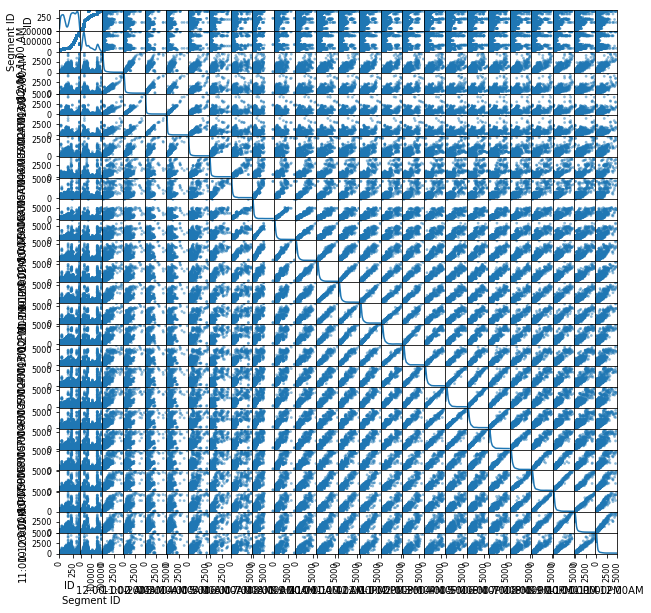

In [18]:
sfig = pd.scatter_matrix(td, s=30, figsize=(10, 10), diagonal='kde')

In [19]:
td.columns.sort_values()

Index(['10:00-11:00AM', '10:00-11:00PM', '11:00-12:00AM', '11:00-12:00PM',
       '12:00-1:00 AM', '12:00-1:00PM', '1:00-2:00AM', '1:00-2:00PM',
       '2:00-3:00AM', '2:00-3:00PM', '3:00-4:00AM', '3:00-4:00PM',
       '4:00-5:00AM', '4:00-5:00PM', '5:00-6:00AM', '5:00-6:00PM',
       '6:00-7:00AM', '6:00-7:00PM', '7:00-8:00AM', '7:00-8:00PM',
       '8:00-9:00AM', '8:00-9:00PM', '9:00-10:00AM', '9:00-10:00PM', 'Date',
       'Direction', 'From', 'ID', 'Roadway Name', 'Segment ID', 'To'],
      dtype='object')

In [20]:
td.head()

,ID,Segment ID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,1,2153,HUGUENOT AVE,WOODROW RD,STAFFORD AVE,NB,02/02/2013,106,74,45.0,...,371,398,324,394,379,329,249,197,187,169
1,1,2153,HUGUENOT AVE,WOODROW RD,STAFFORD AVE,NB,02/03/2013,109,74,55.0,...,308,291,313,253,242,217,210,144,125,79
2,1,2153,HUGUENOT AVE,WOODROW RD,STAFFORD AVE,NB,02/04/2013,36,28,11.0,...,426,425,419,469,425,358,224,185,132,74
3,1,2153,HUGUENOT AVE,WOODROW RD,STAFFORD AVE,NB,02/05/2013,42,28,16.0,...,393,479,441,476,446,424,305,219,171,76
4,1,2153,HUGUENOT AVE,WOODROW RD,STAFFORD AVE,NB,02/06/2013,35,38,12.0,...,383,384,391,369,401,338,236,186,123,76


In [21]:
drop_col=['ID','Segment ID','Roadway Name','From','To','Direction','Date']
tdsum=td.drop(columns=drop_col)
tdsum.head()

,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,3:00-4:00AM,4:00-5:00AM,5:00-6:00AM,6:00-7:00AM,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,106,74,45.0,29.0,29,45.0,71,145.0,213.0,278,...,371,398,324,394,379,329,249,197,187,169
1,109,74,55.0,37.0,26,25.0,47,74.0,111.0,204,...,308,291,313,253,242,217,210,144,125,79
2,36,28,11.0,16.0,32,108.0,168,418.0,493.0,263,...,426,425,419,469,425,358,224,185,132,74
3,42,28,16.0,12.0,34,109.0,193,397.0,499.0,241,...,393,479,441,476,446,424,305,219,171,76
4,35,38,12.0,14.0,31,98.0,195,372.0,490.0,297,...,383,384,391,369,401,338,236,186,123,76


In [22]:
tdsumtotal=tdsum.sum()
tdsumtotal

12:00-1:00 AM    1593980.00
1:00-2:00AM      1186001.00
2:00-3:00AM       943428.16
3:00-4:00AM       823280.82
4:00-5:00AM       864327.00
5:00-6:00AM      1077545.50
6:00-7:00AM      1776670.00
7:00-8:00AM      2673271.16
8:00-9:00AM      3072293.50
9:00-10:00AM     2946417.00
10:00-11:00AM    2896912.00
11:00-12:00PM    2976042.00
12:00-1:00PM     3084089.00
1:00-2:00PM      3170067.00
2:00-3:00PM      3376024.00
3:00-4:00PM      3557591.00
4:00-5:00PM      3563714.00
5:00-6:00PM      3568822.00
6:00-7:00PM      3440468.00
7:00-8:00PM      3102515.00
8:00-9:00PM      2731307.00
9:00-10:00PM     2399095.00
10:00-11:00PM    2152386.00
11:00-12:00AM    1893921.00
dtype: float64

### Filter by borough

In [23]:
tdsumpc=tdsumtotal/tdsumtotal.sum()
tdsumpc

12:00-1:00 AM    0.027076
1:00-2:00AM      0.020146
2:00-3:00AM      0.016026
3:00-4:00AM      0.013985
4:00-5:00AM      0.014682
5:00-6:00AM      0.018304
6:00-7:00AM      0.030179
7:00-8:00AM      0.045410
8:00-9:00AM      0.052188
9:00-10:00AM     0.050049
10:00-11:00AM    0.049208
11:00-12:00PM    0.050553
12:00-1:00PM     0.052388
1:00-2:00PM      0.053848
2:00-3:00PM      0.057347
3:00-4:00PM      0.060431
4:00-5:00PM      0.060535
5:00-6:00PM      0.060622
6:00-7:00PM      0.058442
7:00-8:00PM      0.052701
8:00-9:00PM      0.046395
9:00-10:00PM     0.040752
10:00-11:00PM    0.036562
11:00-12:00AM    0.032171
dtype: float64

In [24]:
tdsumpc.sum()

1.0

### ALL NYC

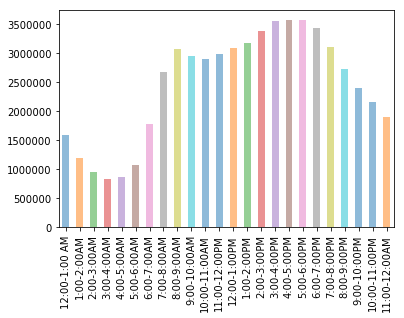

In [25]:
tdsumtotal.plot(kind="bar", alpha=0.5)

##### Figure 1. Total vehicle counts distribution per time of the day in all NYC

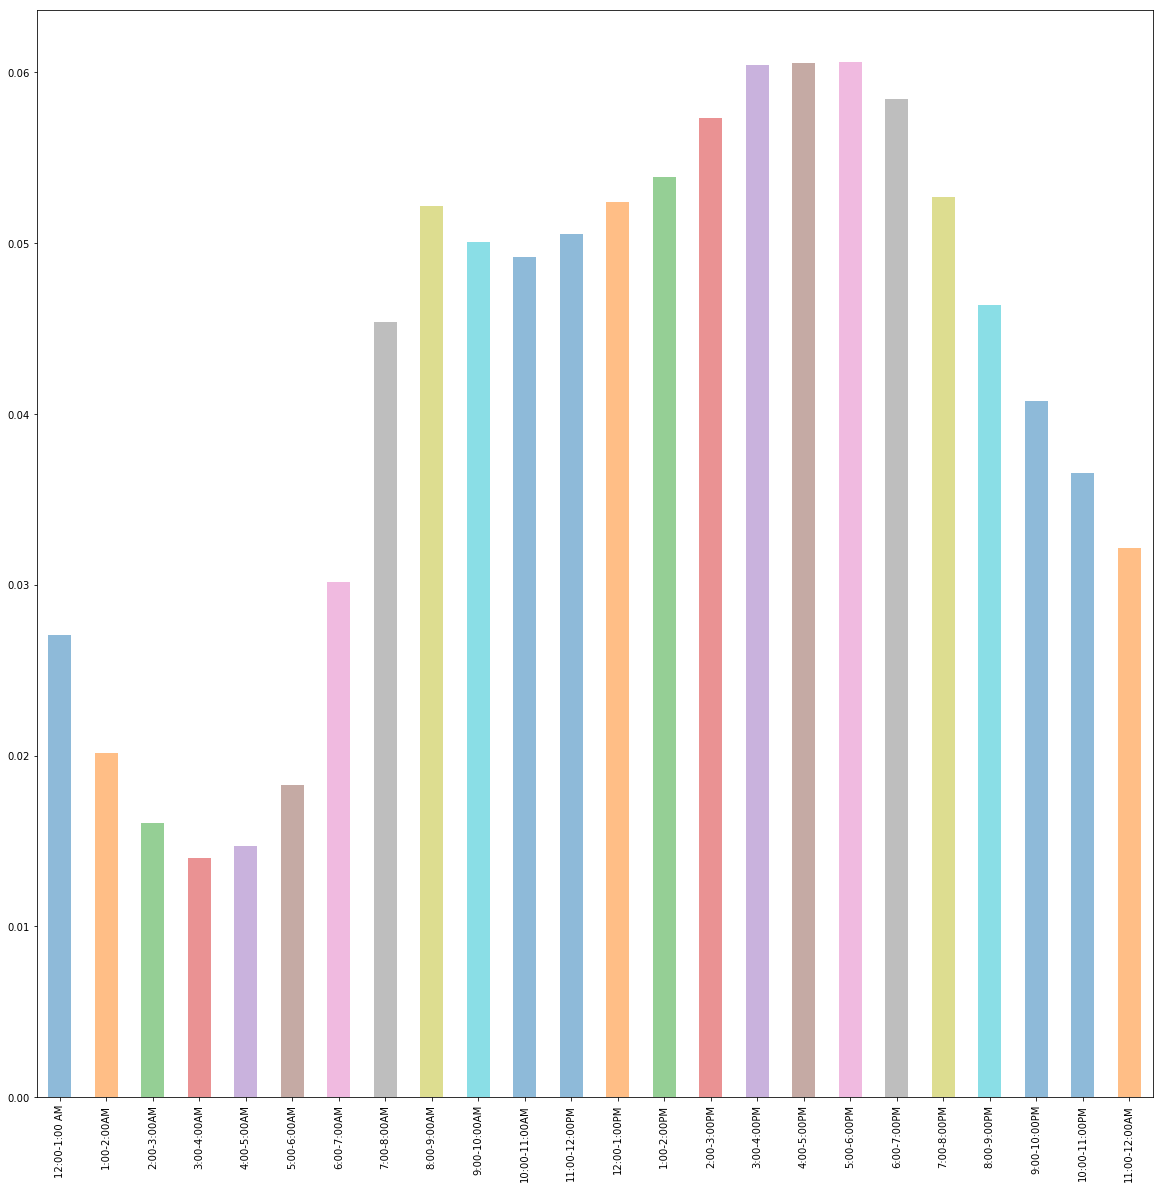

In [26]:
tdsumpc.plot(kind="bar", alpha=0.5,figsize=(20,20))

##### Figure 2. Percentage of vehicle counts distribution per time of the day in all NYC

### Brooklyn

### Manhattan

### Bronx

### Staten Island